# NYC Taxi tip patterns 

## Objective
This analysis aims to describe patterns related to tip amounts that passengers leave to taxi drivers. 

## Data
NYC yellow taxi data for the first half of 2013 was retrieved through https://bigquery.cloud.google.com/table/imjasonh-storage:nyctaxi.trip_data. Subset of the data of 10,000 observations were obtained. For reproducibility, please copy the query in each task and copy to the Query Table text box.

# 0. Imports

In [1]:
import pandas as pd
import numpy as np

import scipy as sp
from scipy import stats

import matplotlib.pylab as pl
import seaborn as sns
sns.set_style('whitegrid')
%pylab inline

import statsmodels.formula.api as smf
import statsmodels.api as sm

Populating the interactive namespace from numpy and matplotlib


/Applications/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 1.	What was the average tip amount in June 2013?  Please give the average tip amount in dollars and the average tip as a proportion of ride cost.  

For this task I query for the rides of only June 2013, a subset of 10000 observations. SQL query:

```
SELECT * FROM [imjasonh-storage:nyctaxi.trip_fare] 
where pickup_datetime between '2013-06-01' and '2013-06-30 23:59:59'
LIMIT 10000
```

## Data read in + cleaning

In [2]:
# reading in data for trip fare June 2013
tripfare6 = pd.read_csv('tripfareJune.csv')
tripfare6.head()

,medallion,hack_license,vendor_id,pickup_datetime,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,922EFFD83A639FEB38CC41E0BB716DB5,51246985B396F628F62CAF5848F45F54,VTS,2013-06-06 08:22:00,CRD,22.0,0.0,0.5,3.5,0.0,26.0
1,084EBAFD06DB6B84F2584B9FA0CEEB82,E70BCB92622D925BA98757D2ECE46641,VTS,2013-06-06 12:29:00,CRD,22.0,0.0,0.5,3.5,0.0,26.0
2,7A01AD8BF11C9B969BBF4CFB5288AE40,612F60FCD2E3152FD1B49E39A6E1D03A,VTS,2013-06-06 13:07:00,CRD,22.0,0.0,0.5,3.5,0.0,26.0
3,8C69BE53D1B7A444055464D22DC952A5,12970308B4C57B79A63DDC591E2BE810,VTS,2013-06-06 12:22:00,CRD,22.0,0.0,0.5,3.5,0.0,26.0
4,0F8F0EE14AA33E24EE9286E29A0C32FE,76000A30938041F073F887F2BE5F4B8F,VTS,2013-06-06 11:44:00,CRD,22.0,0.0,0.5,3.5,0.0,26.0


In [3]:
tripfare6.shape

(10000, 11)

In [4]:
# learning the data
print("characteristics of the tips amount ($) distribution")
tripfare6["tip_amount"].describe()

characteristics of the tips amount ($) distribution


count    10000.000000
mean         5.607911
std          4.112583
min          0.010000
25%          3.500000
50%          5.380000
75%          7.200000
max        117.500000
Name: tip_amount, dtype: float64

### ** It seems that the data do not include 0.0 dollars tips. Also, the maximum tip seems to be too large and could be not valid >>
## AD statistical test to assess if the tip amount follows a Gaussian distribution, in order to define a threshold:

In [5]:
# statistical significance threshold
alpha = 0.05

In [6]:
adTips = sp.stats.anderson((tripfare6.tip_amount - 
                tripfare6.tip_amount.mean())  / 
                    tripfare6.tip_amount.std(), "norm")
verb = "does not " if adTips[0] > adTips[1][adTips[2] == alpha * 100] else "does "
print ("The distribution of tips " + verb + "follow a normal distribution (p < 0.05) " + 
      "according to the AD test")

The distribution of tips does not follow a normal distribution (p < 0.05) according to the AD test


### As the data does not follow Gaussian distribution, I will set the upper threshold as a 50% tip from fare amount. 

In [7]:
# calculating average tip as a proportion of ride cost
tripfare6['tippercent'] = tripfare6['tip_amount'] / tripfare6['fare_amount'] 

## Further learning of the tip percent distribution

In [8]:
print("characteristics of the tips amount ($) distribution")
tripfare6["tippercent"].describe()

characteristics of the tips amount ($) distribution


count    10000.000000
mean         0.232780
std          0.717081
min          0.000100
25%          0.200000
50%          0.200000
75%          0.250000
max         47.000000
Name: tippercent, dtype: float64

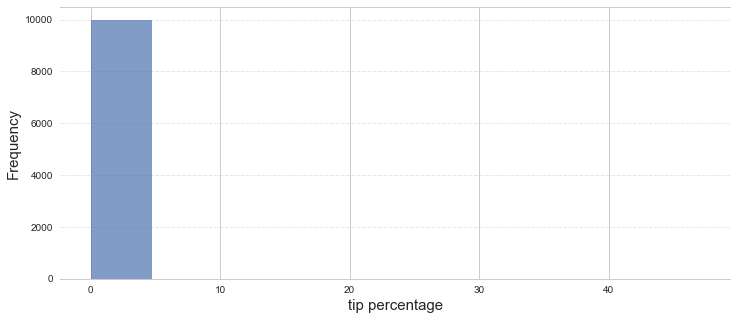

In [9]:
fig = pl.figure(figsize(12,5))

ax = tripfare6['tippercent'].plot(kind="hist", alpha=0.7)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_xlabel("tip percentage", fontsize=15)
ax.set_ylabel("Frequency", fontsize=15)
plt.grid(linewidth=0.5, axis='y', linestyle='-.')

### Fig.1
Histogram of the distribution of tips as percentage of fare for all yellowcab rides in June 2013, NYC. The distribution is dominated by very low percentage tips, and it stretches to 4700%.

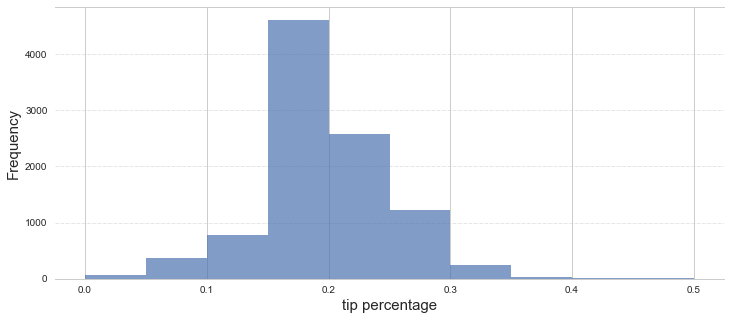

In [10]:
# assuming a reasinable tip to be up to 50% of fare amount
fig = pl.figure(figsize(12,5))

ax = tripfare6[tripfare6['tippercent'] <= 0.5]['tippercent'].plot(kind="hist", alpha=0.7)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_xlabel("tip percentage", fontsize=15)
ax.set_ylabel("Frequency", fontsize=15)
plt.grid(linewidth=0.5, axis='y', linestyle='-.')

### Fig.2
Histogram of the distribution of tips as percentage of fare for the subset of data from Figure 1 where the tip is less than 50% of the fare. The distribution is now bellshaped, with mean value near the standard 21% tip with a standard deviation of ~5.5%

In [11]:
tripfare6[tripfare6['tippercent'] <= 0.5]['tippercent'].describe()[1:3]

mean    0.208662
std     0.054624
Name: tippercent, dtype: float64

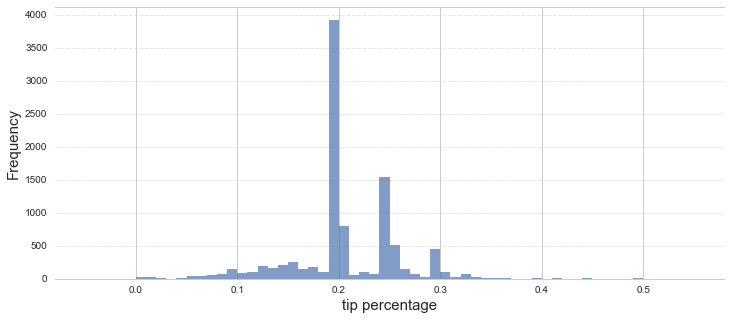

In [12]:
fig = pl.figure(figsize(12,5))

ax = tripfare6[tripfare6['tippercent'] <= 0.5]['tippercent'].plot(kind="hist",
                                            bins=np.arange(-0.05, 0.55, 0.01), alpha=0.7)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_xlabel("tip percentage", fontsize=15)
ax.set_ylabel("Frequency", fontsize=15)
plt.grid(linewidth=0.5, axis='y', linestyle='-.')

### Fig.3
As Figure 2, but plotted with smaller bins of size 0.01%. The new binning reveals a sharp peak at 20% of the trip fare, as well as smaller picks at 25% and 30%: these are easily explained by automated tipping percentage options on credit card machines, as well as standard tipping costumes.

## Removing observations outside the threshold of 50% tip

In [13]:
# remove outliers from data
tripfare6 = tripfare6[tripfare6['tippercent'] <= 0.5]
tripfare6.shape

(9924, 12)

### 9924 observations were found valid for this analysis.

## Average tip amount (US dollars)

In [14]:
# Average tip amount (US dollars)
print("The average tip amount in June 2013 in US dollars, for all valid observations, is {:.3f}$, with standard deviation of {:.3f}"
      .format(tripfare6['tip_amount'].mean(), tripfare6['tip_amount'].std()))

The average tip amount in June 2013 in US dollars, for all valid observations, is 5.532$, with standard deviation of 3.609


## Average tip amount (proportion of ride cost)

In [15]:
print("The average tip amount in June 2013 as proportion of ride cost, for all valid observations, is {:.3f}, with standard deviation of {:.3f}"
      .format(tripfare6['tippercent'].mean(), tripfare6['tippercent'].std()))

The average tip amount in June 2013 as proportion of ride cost, for all valid observations, is 0.209, with standard deviation of 0.055


# 2.	Which driver (identified by hack license) had the largest change in tip amount from the first 5 months of 2013 to June 2013?

For this task I query for the rides of Jan-May 2013, a subset of 10000 observations. SQL query:
```
SELECT * FROM [imjasonh-storage:nyctaxi.trip_fare] 
where pickup_datetime between '2013-01-01' and '2013-05-31 23:59:59'
LIMIT 10000
```

** Calculating the change of _mean tip amount_ (US dollars) between the first five months of 2013 and June 2013.

In [16]:
# reading in data for trip fare Jan-May 2013
tripfare1 = pd.read_csv('fareJanMay.csv')
tripfare1.head(3)

,medallion,hack_license,vendor_id,pickup_datetime,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,F336B7BA8506D6FA12FF8F266282EFD0,B9D3C8A665791430FBD78D7E87D6BB0C,VTS,2013-04-01 07:37:00,CRD,22.0,0.0,0.5,0.5,0.0,23.0
1,9D77B00127FA52A93E9CEA212DA158F9,8A23C66F21891C19A495AA19302AD788,VTS,2013-04-01 10:06:00,CRD,22.0,0.0,0.5,0.5,0.0,23.0
2,11420286E3AE843E8B91698FE87DB5C6,8929339F121F1DDC3A83204B5123DD9F,VTS,2013-04-01 19:13:00,CRD,22.0,1.0,0.5,0.5,0.0,24.0


In [17]:
tripfare1.shape

(10000, 11)

In [18]:
# learning the data
tripfare1['tip_amount'].describe()

count    10000.000000
mean         6.437296
std          3.427592
min          0.010000
25%          4.800000
50%          5.700000
75%          7.050000
max         92.500000
Name: tip_amount, dtype: float64

### ** _As in task 1:_ It seems that Jan-May data do not include 0.0 dollars tips. Also, the maximum tip seems to be too large and could be not valid; a threshold of 50% tip from fare amount will be assumed.¶

In [19]:
# calculating average tip as a proportion of ride cost
tripfare1['tippercent'] = tripfare1['tip_amount'] / tripfare1['fare_amount'] 

In [20]:
# remove outliers from data
tripfare1 = tripfare1[tripfare1['tippercent'] <= 0.5]
tripfare1.shape

(9918, 12)

### ** 9918 observations were found valid for this task.

In [21]:
# creating df for grouped by drivers (identified by hack license) and tip amount
drivertip1 = pd.DataFrame(tripfare1.tip_amount.groupby([tripfare1.hack_license]).mean())
#drivertip1 = drivertip1.drop(['tippercent'], axis=1)
drivertip1 = drivertip1.reset_index()
drivertip1.columns = ['driver', 'tip1-5']
drivertip1.head(3)

,driver,tip1-5
0,001C8AAB90AEE49F36FCAA7B4136C81A,6.75
1,0025133AD810DBE80D35FCA8BF0BCA1F,6.50
2,002C093A2CB9FD40C8C54AB5D158FC47,4.50


In [22]:
drivertip6 = pd.DataFrame(tripfare6.tip_amount.groupby([tripfare6.hack_license]).mean())
drivertip6 = drivertip6.reset_index()
drivertip6.columns = ['driver', 'tip6']
drivertip6.head(3)

,driver,tip6
0,00184958F5D5FD0A9EC0B115C5B55796,6.2
1,001C8AAB90AEE49F36FCAA7B4136C81A,7.3
2,002C093A2CB9FD40C8C54AB5D158FC47,4.6


In [23]:
# merging two dataframes 
drivertipAll = drivertip1.merge(drivertip6, on = 'driver')
drivertipAll.shape

(2562, 3)

### ** 2562 drivers were found in both datasets

In [24]:
drivertipAll.head()

,driver,tip1-5,tip6
0,001C8AAB90AEE49F36FCAA7B4136C81A,6.75,7.300000
1,002C093A2CB9FD40C8C54AB5D158FC47,4.50,4.600000
2,0046F1E91AA13DEDE4F6EE775C6293AB,4.00,5.783333
3,007357E7FFE212879B9B85C7F4681AE5,4.85,4.300000
4,007E686365B4421FB22F8F2FAF21FBC1,5.00,5.600000


In [25]:
# calculating tip amount (mean) change
drivertipAll['tipchange'] = drivertipAll['tip6'] - drivertipAll['tip1-5']
drivertipAll.head()

,driver,tip1-5,tip6,tipchange
0,001C8AAB90AEE49F36FCAA7B4136C81A,6.75,7.300000,0.550000
1,002C093A2CB9FD40C8C54AB5D158FC47,4.50,4.600000,0.100000
2,0046F1E91AA13DEDE4F6EE775C6293AB,4.00,5.783333,1.783333
3,007357E7FFE212879B9B85C7F4681AE5,4.85,4.300000,-0.550000
4,007E686365B4421FB22F8F2FAF21FBC1,5.00,5.600000,0.600000


In [26]:
# sorting 'tipchange' in order to find out the largest change in tip amount
drivertipAll['tipchange'].abs().sort_values(ascending=False)[:10]

1017    25.000
805     21.600
1125    20.400
354     19.825
57      19.600
398     18.375
134     16.950
823     16.000
2472    15.900
2243    15.600
Name: tipchange, dtype: float64

In [27]:
# identifying the driver
drivertipAll.loc[1017]

driver       668482008D457EACF21049DEB67C7A9B
tip1-5                                      5
tip6                                       30
tipchange                                  25
Name: 1017, dtype: object

## Answer: 
Driver **hack_license no. 668482008D457EACF21049DEB67C7A9B** had average tip amount of **5 US Dollars** in Jan-May 2013 and **30 US Dollars** in June, the highest change in tip amount from all drivers that were found in both periods of time. 

# 3.	Does distance traveled affect dollar tip amounts and/or tips as percent of ride cost?
#### _Assessing colinearity of trip distance and tip amount / precent_
Data of table _trip_data_ is only for months February (02/2013) and May (05/2013). Thus I query for the trip_data + trip_fare data of May 2013 only, a subset of 10000 observations. SQL query:
```
SELECT * FROM [imjasonh-storage:nyctaxi.trip_data] 
where pickup_datetime between '2013-05-01' and '2013-05-31 23:59:59'
LIMIT 10000
```
and:
```
SELECT * FROM [imjasonh-storage:nyctaxi.trip_fare] 
where pickup_datetime between '2013-05-01' and '2013-05-31 23:59:59'
LIMIT 10000
```

In [28]:
tripfare = pd.read_csv('fare5.csv')
tripdata = pd.read_csv('data5.csv')
tripdata.head()

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,000318C2E3E6381580E5C99910A60668,4F463F528AF7914347A78753E4D2C379,VTS,1,NaN,2013-05-02 09:46:00,2013-05-02 09:58:00,6,720,1.42,-73.991974,40.744053,-73.980209,40.760834
1,000318C2E3E6381580E5C99910A60668,FA9844DF87F8CD641DB58BC2A0E466F8,VTS,1,NaN,2013-05-12 13:13:00,2013-05-12 13:19:00,4,360,1.26,-73.973801,40.792110,-73.984917,40.779270
2,000318C2E3E6381580E5C99910A60668,4F463F528AF7914347A78753E4D2C379,VTS,1,NaN,2013-05-03 16:24:00,2013-05-03 16:32:00,6,480,1.38,-73.951340,40.804722,-73.938263,40.818798
3,000318C2E3E6381580E5C99910A60668,D4B558D3E7A4ECAAB98FCC9DBFE9A1C6,VTS,1,NaN,2013-05-22 12:07:00,2013-05-22 12:12:00,4,300,0.66,-73.970657,40.755642,-73.965393,40.763103
4,000318C2E3E6381580E5C99910A60668,4F463F528AF7914347A78753E4D2C379,VTS,1,NaN,2013-05-09 11:38:00,2013-05-09 12:04:00,6,1560,2.11,-74.007858,40.703537,-73.987892,40.722717


In [29]:
tripfare.shape

(10000, 11)

In [30]:
trips = tripdata.merge(tripfare, on=['pickup_datetime'])
trips.head(2)

,medallion_x,hack_license_x,vendor_id_x,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,...,medallion_y,hack_license_y,vendor_id_y,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,000318C2E3E6381580E5C99910A60668,FA9844DF87F8CD641DB58BC2A0E466F8,VTS,1,NaN,2013-05-12 13:13:00,2013-05-12 13:19:00,4,360,1.26,...,16CAFC779BE8FB877073B98DC36926BC,CE6F6C0974F6E2B490EC87F118897FA5,VTS,CRD,4.0,0.0,0.5,2.0,0.0,6.5
1,000318C2E3E6381580E5C99910A60668,FA9844DF87F8CD641DB58BC2A0E466F8,VTS,1,NaN,2013-05-12 13:13:00,2013-05-12 13:19:00,4,360,1.26,...,012F172C0351A4767F60F6B6B2CF9E86,D64BE6233FA523225C683CCD44FF2750,VTS,CRD,5.0,0.0,0.5,1.5,0.0,7.0


In [31]:
trips.shape

(2371, 24)

### ** 2371 rides were validly merged and will be included in the analysis of this task.

In [32]:
# learning the data
trips['tip_amount'].describe()

count    2371.000000
mean        1.147912
std         1.024007
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        15.000000
Name: tip_amount, dtype: float64

### ** The data include 0.0 dollars tips. The maximum tip is 15 dollars; I will set again a threshold of 50% tip from fare amount. Also, I will drop 0 dollars tips to better assess the correlation.

In [33]:
# calculating tip % + cleaning the dataset
trips = trips[['hack_license_x', 'trip_distance', 'fare_amount', 'tip_amount']]
trips['tippercent'] = trips['tip_amount'] / trips['fare_amount'] * 100
trips.head()

,hack_license_x,trip_distance,fare_amount,tip_amount,tippercent
0,FA9844DF87F8CD641DB58BC2A0E466F8,1.26,4.0,2.0,50.0
1,FA9844DF87F8CD641DB58BC2A0E466F8,1.26,5.0,1.5,30.0
2,FA9844DF87F8CD641DB58BC2A0E466F8,1.26,5.0,0.0,0.0
3,FA9844DF87F8CD641DB58BC2A0E466F8,1.26,5.0,1.0,20.0
4,FA9844DF87F8CD641DB58BC2A0E466F8,1.26,5.0,1.0,20.0


In [34]:
trips['tippercent'].describe()

count    2371.000000
mean       21.589738
std        10.845721
min         0.000000
25%        20.000000
50%        20.000000
75%        25.000000
max       200.000000
Name: tippercent, dtype: float64

In [35]:
trips = trips[trips['tippercent'] <= 50]
trips = trips[trips['tippercent'] != 0]

trips.shape

(2229, 5)

### 2229 observations were found valid for this analysis.

## Linear Model to assess collinearity between tip % and trip distance (miles)

In [36]:
# modeling tip with distance
tdmodel = smf.ols(formula='tip_amount ~ trip_distance', data=trips).fit()
tdmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             tip_amount   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.328
Date:                Thu, 19 Apr 2018   Prob (F-statistic):              0.249
Time:                        22:06:35   Log-Likelihood:                -3095.2
No. Observations:                2229   AIC:                             6194.
Df Residuals:                    2227   BIC:                             6206.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.1595      0.026     44.885      0.000       1.109       1.210
trip_distance     0.0064      0.006      1.153      0.249      -0.004       0.017
==============================================================================
Omnibus:                     2852.677   Durbin-Watson:                   1.796
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           398052.501
Skew:                           7.046   Prob(JB):                         0.00
Kurtosis:                      66.932   Cond. No.                         5.95
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

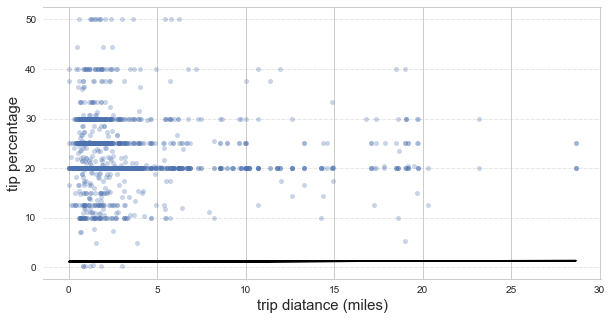

In [37]:
fig = pl.figure(figsize(10,5))

ax = trips.plot.scatter(x='trip_distance', y='tippercent', alpha=0.3)
ax.plot(trips.trip_distance, tdmodel.fittedvalues, 'k')

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_xlabel("trip diatance (miles)", fontsize=15)
ax.set_ylabel("tip percentage", fontsize=15)
plt.grid(linewidth=0.5, axis='y', linestyle='-.')

### Fig.4
Scatter plot of tip % against trip distance for May 2013 rides with non-zero tip and tip < 50% of fare amount. Also plotted (black line) is a linear fit of trip duration to fare, revealing a low predictive power of a model of trip fare from trip duration (Rsquares = 0.001 or 0.1% of the variance in tip % explained by distance). The fixed tip % of 10%, 20%, 25%, 30%, 40% can be considered outliers for the purpose of this analysis and will be removed in the next step.

In [38]:
trips[~(trips['tippercent'] == 25)].shape

(1929, 5)

In [39]:
# removing 

# cuts
trips_cut = trips[trips['tippercent'] != 20]
trips_cut = trips_cut[trips_cut['tippercent'] != 10]
trips_cut = trips_cut[trips_cut['tippercent'] != 25]
trips_cut = trips_cut[trips_cut['tippercent'] != 30]
trips_cut = trips_cut[trips_cut['tippercent'] != 40]
trips_cut = trips_cut[trips_cut['tippercent'] != 15]
trips_cut = trips_cut[trips_cut['tippercent'] != 12]
trips_cut = trips_cut[trips_cut['tippercent'] != 50]

trips_cut.head()

,hack_license_x,trip_distance,fare_amount,tip_amount,tippercent
16,4F463F528AF7914347A78753E4D2C379,1.15,4.0,0.5,12.5
19,3417112F7EC6927AC309EFA59AAA4F7F,0.89,4.0,0.5,12.5
25,4F463F528AF7914347A78753E4D2C379,0.83,4.0,0.5,12.5
45,5A8D52FC0D079DFE7CCFA72AE0000FF9,0.86,4.0,0.5,12.5
52,DD63AD6504C4A40A301AEE0C5CE41C28,5.72,4.0,1.5,37.5


In [40]:
trips_cut.shape

(268, 5)

In [41]:
# modeling tip with distance
tdmodel2 = smf.ols(formula='tip_amount ~ trip_distance', data=trips_cut).fit()
tdmodel2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             tip_amount   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.520
Date:                Thu, 19 Apr 2018   Prob (F-statistic):              0.219
Time:                        22:06:42   Log-Likelihood:                -604.84
No. Observations:                 268   AIC:                             1214.
Df Residuals:                     266   BIC:                             1221.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.0810      0.177     11.740      0.000       1.732       2.430
trip_distance     0.0481      0.039      1.233      0.219      -0.029       0.125
==============================================================================
Omnibus:                      124.772   Durbin-Watson:                   1.687
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              422.139
Skew:                           2.087   Prob(JB):                     2.16e-92
Kurtosis:                       7.515   Cond. No.                         5.79
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

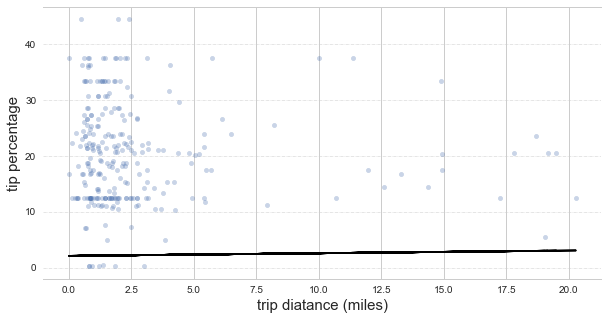

In [42]:
fig = pl.figure(figsize(10,5))

ax = trips_cut.plot.scatter(x='trip_distance', y='tippercent', alpha=0.3)
ax.plot(trips_cut.trip_distance, tdmodel2.fittedvalues, 'k')

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_xlabel("trip diatance (miles)", fontsize=15)
ax.set_ylabel("tip percentage", fontsize=15)
plt.grid(linewidth=0.5, axis='y', linestyle='-.')

## Fig.5
Scatter plot of tip % against trip distance for May 2013 rides with non-zero tip and tip < 50% of fare amount, fixed tip % of 10%, 20%, 25%, 30%, 40% had been removed. Also plotted (black line) is a linear fit of trip duration to fare, revealing a low predictive power of a model of trip fare from trip duration (R2 = 0.005 or 0.5% of the variance in tip % explained by distance). It is worth considering build the model only on short distance.

### Threshold for trip distance:

In [45]:
adDist = sp.stats.anderson((trips_cut.trip_distance - 
                trips_cut.trip_distance.mean())  / 
                    trips_cut.trip_distance.std(), "norm")
verb = "does not " if adDist[0] > adDist[1][adDist[2] == alpha * 100] else "does "
print ("The distribution of trip distance " + verb + "follow a normal distribution (p < 0.05) " + 
      "according to the AD test")

The distribution of trip distance does not follow a normal distribution (p < 0.05) according to the AD test


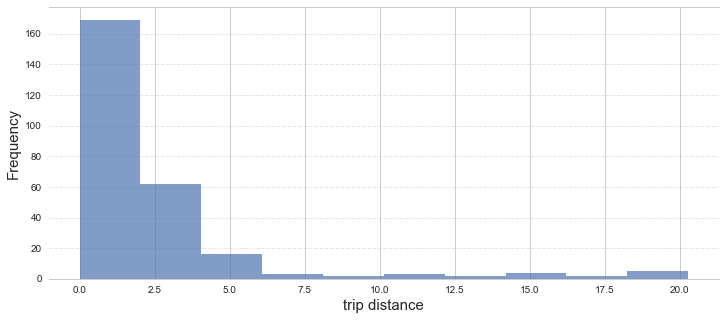

In [46]:
# assuming a reasinable tip to be up to 50% of fare amount
fig = pl.figure(figsize(12,5))

ax = trips_cut['trip_distance'].plot(kind="hist", alpha=0.7)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_xlabel("trip distance", fontsize=15)
ax.set_ylabel("Frequency", fontsize=15)
plt.grid(linewidth=0.5, axis='y', linestyle='-.')

## Fig.6
Histogram of the distribution of trip distance. Most of the trips are bellow ~7 miles.

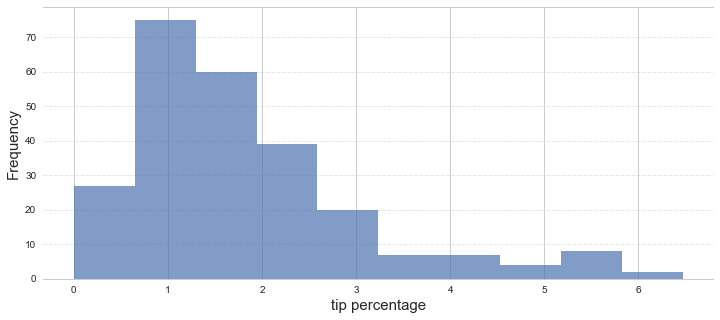

In [47]:
# assuming a reasinable tip to be up to 50% of fare amount
fig = pl.figure(figsize(12,5))

ax = trips_cut[trips_cut['trip_distance'] <= 7.5]['trip_distance'].plot(kind="hist", alpha=0.7)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_xlabel("tip percentage", fontsize=15)
ax.set_ylabel("Frequency", fontsize=15)
plt.grid(linewidth=0.5, axis='y', linestyle='-.')

## Fig.7
Histogram of the distribution of trip distance, trips of 7.5 miles or bellow.

In [48]:
trips_short = trips_cut[trips_cut['trip_distance'] <= 7.5]
trips_short.shape

(249, 5)

In [49]:
# modeling tip with distance
tdmodel3 = smf.ols(formula='tip_amount ~ trip_distance', data=trips_short).fit()
tdmodel3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             tip_amount   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     3.022
Date:                Thu, 19 Apr 2018   Prob (F-statistic):             0.0834
Time:                        22:07:21   Log-Likelihood:                -562.38
No. Observations:                 249   AIC:                             1129.
Df Residuals:                     247   BIC:                             1136.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.8179      0.259      7.021      0.000       1.308       2.328
trip_distance     0.2026      0.117      1.738      0.083      -0.027       0.432
==============================================================================
Omnibus:                      119.754   Durbin-Watson:                   1.723
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              415.564
Skew:                           2.126   Prob(JB):                     5.77e-91
Kurtosis:                       7.688   Cond. No.                         4.47
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

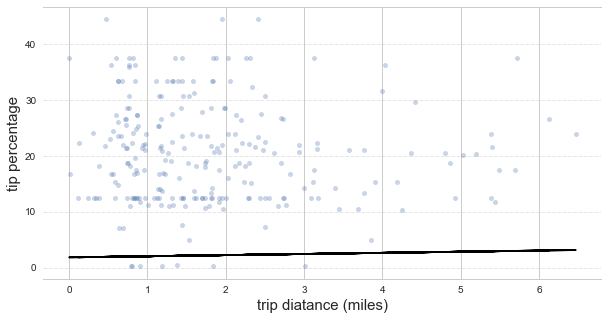

In [50]:
fig = pl.figure(figsize(10,5))

ax = trips_short.plot.scatter(x='trip_distance', y='tippercent', alpha=0.3)
ax.plot(trips_short.trip_distance, tdmodel3.fittedvalues, 'k')

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_xlabel("trip diatance (miles)", fontsize=15)
ax.set_ylabel("tip percentage", fontsize=15)
plt.grid(linewidth=0.5, axis='y', linestyle='-.')

## Fig.8
Scatter plot of tip % against trip distance for May 2013 rides with non-zero tip and tip < 50% of fare amount, fixed tip % of 10%, 20%, 25%, 30%, 40% had been removed, as well as trips longer than 7.5 miles. Also plotted (black line) is a linear fit of trip duration to fare, revealing a low predictive power of a model of trip fare from trip duration (R2 = 0.012 or 1.2% of the variance in tip % explained by distance).

## 4.	How would you assess whether your response to #3 is different for different drivers? Answer theoretically, no need to implement your analysis. 

- (**If there were data of drivers’ ranking**) I can assume that drivers with different ranks would show different tipping patterns of their passengers. According to data availability of drivers’ rankings, I will build the model as in task 3 for each ranking (1-5) group of drivers.  
- I can **cluster drivers by their tip amount** (US dollars or % from fare) using clustering technique such as **K-means**, assuming k=4 clusters, and remodel the OLS for each of the clusters.
- More thorough: I assume that passengers from different neighborhoods and different socio-economic backgrounds will have different tipping patterns. Thus, I can define trip origin using the pickup_longitude and pickup_latitude. I will merge NYC census tracts shapefiles into my dataset using geopandas, and will incorporate ACS median income data in order to assign census tracts to income groups (assuming four groups / quartiles), then find each driver’s common areas of work and will assign them to the income group. Finally, I will remodel the tip % over trip distance for each income group of drivers. 

## 5.	We’re concerned that a few bad drivers may be under-reporting cash tips.  Does the difference between cash tips and credit card tips differ by time of day? Day of week?

For this analysis I will use the same dataset of trip_fare from **task 3**. 

nyctaxi payment_type data are displayed as follows:
    
     credit card = CRD
     cash = CSH
     unknown = UNK
    
** 'NOC' and 'DIS' payment types were not include in this analysis

In [51]:
tripfare = tripfare6

In [52]:
tripfare.shape

(9924, 12)

In [53]:
# learning the data
print("characteristics of the tips amount ($) distribution")
tripfare["tip_amount"].describe()

characteristics of the tips amount ($) distribution


count    9924.000000
mean        5.532402
std         3.608504
min         0.010000
25%         3.500000
50%         5.380000
75%         7.200000
max        43.830000
Name: tip_amount, dtype: float64

### The data does not include 0.0 dollars tips. The maximum tip is 117.5 dollars; a threshold of 50% tip will be applied.

In [54]:
# tip percent
tripfare['tippercent'] = tripfare['tip_amount'] / tripfare['fare_amount']

In [65]:
# remove outliers from data
ptype = tripfare[tripfare['tippercent'] <= 0.5]
ptype.shape

(9924, 12)

### ** 9924 observations were found valid

In [66]:
ptype.payment_type.value_counts()

CRD    9824
CSH      95
NOC       3
UNK       1
DIS       1
Name: payment_type, dtype: int64

### ** 9824 credit card payed rides and 95 CSH will be included in the analysis of this task.

In [67]:
ptype = ptype.sort_values(['pickup_datetime'])
ptype = ptype.drop(['medallion', 'vendor_id', 'fare_amount',
            'surcharge', 'mta_tax', 'tolls_amount', 'total_amount', 'tippercent'], axis=1)
ptype.head(3)

,hack_license,pickup_datetime,payment_type,tip_amount
3173,1EECB392F960CC044315A28BF7C4CEED,2013-06-02 12:17:00,UNK,10.00
9630,BB4B1645ECEBC8E8B90835F631F81332,2013-06-03 08:27:00,CRD,1.55
7567,C3C525B62BE6A2E896917EA855A2EB5D,2013-06-03 19:27:24,CSH,14.55


In [68]:
ptype['pickup_datetime'] = pd.to_datetime(ptype['pickup_datetime'])
ptype['hour'] = ptype['pickup_datetime'].dt.hour
ptype['day'] = ptype['pickup_datetime'].dt.day

ptype.head()

,hack_license,pickup_datetime,payment_type,tip_amount,hour,day
3173,1EECB392F960CC044315A28BF7C4CEED,2013-06-02 12:17:00,UNK,10.00,12,2
9630,BB4B1645ECEBC8E8B90835F631F81332,2013-06-03 08:27:00,CRD,1.55,8,3
7567,C3C525B62BE6A2E896917EA855A2EB5D,2013-06-03 19:27:24,CSH,14.55,19,3
7495,709490A8AD180DA97647D2F55DEEF4DF,2013-06-04 02:49:12,CSH,17.00,2,4
7569,E8D9F945738C84EF76325C8ECBE64982,2013-06-04 05:55:02,CSH,10.00,5,4


In [69]:
ptype['pickup_datetime'].describe()

count                    9924
unique                   1247
top       2013-06-06 09:00:00
freq                       26
first     2013-06-02 12:17:00
last      2013-06-23 20:22:20
Name: pickup_datetime, dtype: object

In [70]:
ptype['weekday'] = ptype['pickup_datetime'].dt.dayofweek
ptype[::800]

,hack_license,pickup_datetime,payment_type,tip_amount,hour,day,weekday
3173,1EECB392F960CC044315A28BF7C4CEED,2013-06-02 12:17:00,UNK,10.00,12,2,6
3484,031C0778C525511CFA67C436FDD023F1,2013-06-06 03:05:00,CRD,12.50,3,6,3
4566,03AF809EE8658B746A2B08649F0D303B,2013-06-06 06:29:00,CRD,4.90,6,6,3
6036,EE816625AC7BA336AE7CA144F8565876,2013-06-06 07:41:00,CRD,6.00,7,6,3
9992,841C64BF2AB653FC8A42F1050A3DF46E,2013-06-06 08:32:00,CRD,2.25,8,6,3
4787,435923C89514F75E495DF1C6C3A204E0,2013-06-06 09:22:00,CRD,5.10,9,6,3
128,00AE05F56D451E89E6F83EBE384FF5E6,2013-06-06 10:15:00,CRD,4.40,10,6,3
988,888ADCF92D38555FD92764434BED7CAA,2013-06-06 11:08:00,CRD,5.20,11,6,3
4121,F507ECAB0004B94FD014764F183F4E67,2013-06-06 12:03:00,CRD,4.50,12,6,3
521,29A5F01CE49ABBB4970D70378EE2C6F1,2013-06-06 12:56:00,CRD,4.00,12,6,3


In [71]:
ptype['weekday'].value_counts()

3    9729
6     120
4      49
2      11
5       7
1       6
0       2
Name: weekday, dtype: int64

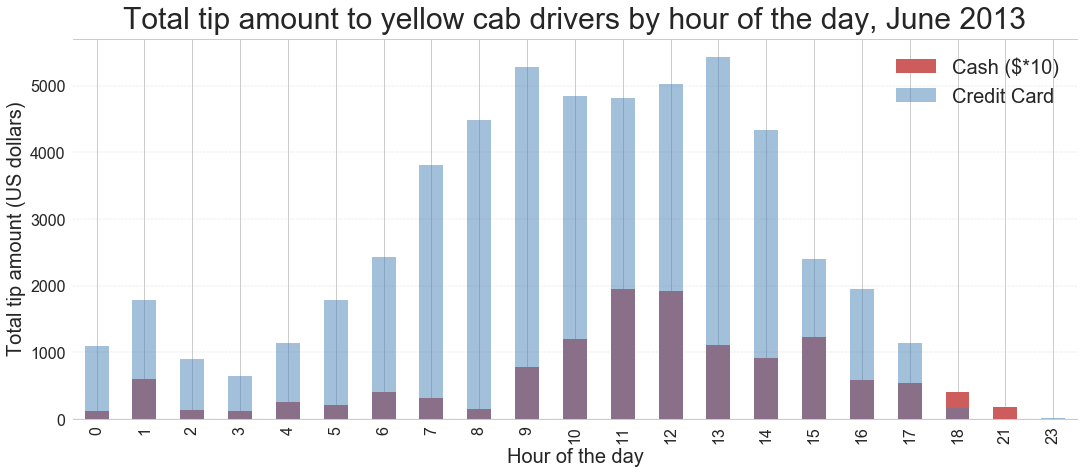

In [72]:
fig = pl.figure(figsize(18,7))

(ptype[ptype['payment_type'] == 'CSH']['tip_amount'].groupby([ptype['hour']]).sum()*10)\
.plot(kind="bar", color='IndianRed', label='Cash ($*10)')
ax = (ptype[ptype['payment_type'] == 'CRD']['tip_amount'].groupby([ptype['hour']]).sum())\
.plot(kind="bar", color='SteelBlue', alpha=0.5, label='Credit Card', fontsize=16)

pl.xlabel('Hour of the day', fontsize=20)
pl.ylabel('Total tip amount (US dollars)', fontsize=20)
pl.title('Total tip amount to yellow cab drivers by hour of the day, June 2013', fontsize=30, y=1.01)
pl.legend(prop={'size': 20})

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.grid(linewidth=0.35, axis='y', linestyle='-.')

## Fig.9
Bar plot of Total tip amount by hour of the day, for cash payed yellow cab rides and credit card payed yellow cab rides, occurring in June 2013. Cash total tip amount is multiplied by 10 in order to compare the two payment types efficiently. According to the graph, the difference between cash tips and credit card tips changes between day time and night time, although this change does not seem to be very meaningful.

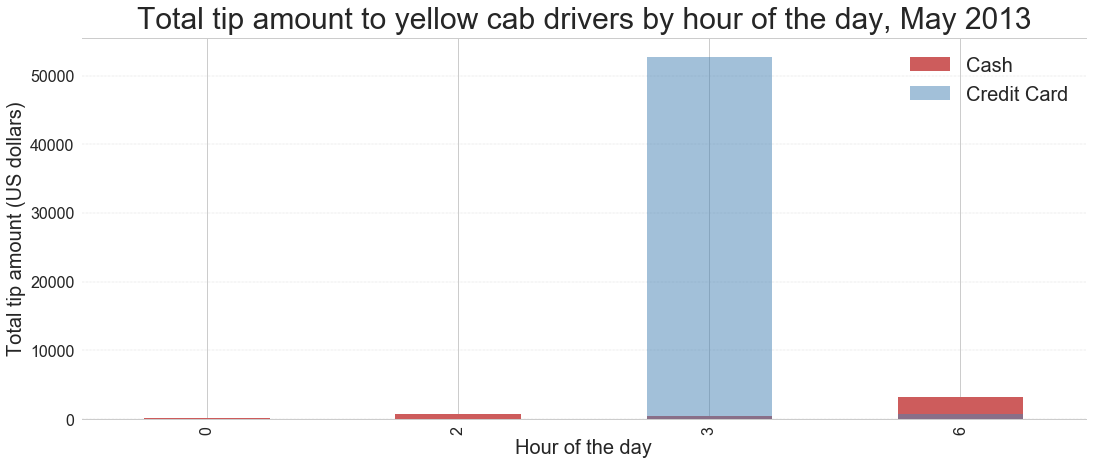

In [73]:
fig = pl.figure(figsize(18,7))

(ptype[ptype['payment_type'] == 'CSH']['tip_amount'].groupby([ptype['weekday']]).sum()*10)\
.plot(kind="bar", color='IndianRed', label='Cash')
ax = (ptype[ptype['payment_type'] == 'CRD']['tip_amount'].groupby([ptype['weekday']]).sum())\
.plot(kind="bar", color='SteelBlue', alpha=0.5, label='Credit Card', fontsize=16)

pl.xlabel('Hour of the day', fontsize=20)
pl.ylabel('Total tip amount (US dollars)', fontsize=20)
pl.title('Total tip amount to yellow cab drivers by hour of the day, May 2013', fontsize=30, y=1.01)
pl.legend(prop={'size': 20})

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.grid(linewidth=0.35, axis='y', linestyle='-.')

## 6.	Which five taxi drivers do you think were under-reporting tips the most?
Assuming the lowest sum of cash tips to be the most under-reporting drivers, I isolated the _'CSH' payment type_ and grouped by driver (_hack_license_), calculating the sum of _tip_amount_ and sorting by the _tip_amount_ column, viewing the top 5 rows.

In [74]:
ptype[ptype.payment_type == 'CSH'].groupby(ptype.hack_license).sum()['tip_amount'].sort_values()[:5]

hack_license
BBB0371651B842361E8068F803BD5AFE    0.01
9B6D45D23A986E2F69F923166D14785D    0.08
CFE3D545806FCF6E3E8F885674EB1B74    0.08
82527F99E55088736782ACF292113804    0.90
A081CF55A1E8BA606CBEEAB1F5BBD900    2.55
Name: tip_amount, dtype: float64

## 7.	Which other factors contribute to determining tip amount?  

In [79]:
tripfare = pd.read_csv('fare5.csv')
tripdata = pd.read_csv('data5.csv')
tripdata.head(2)

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,000318C2E3E6381580E5C99910A60668,4F463F528AF7914347A78753E4D2C379,VTS,1,NaN,2013-05-02 09:46:00,2013-05-02 09:58:00,6,720,1.42,-73.991974,40.744053,-73.980209,40.760834
1,000318C2E3E6381580E5C99910A60668,FA9844DF87F8CD641DB58BC2A0E466F8,VTS,1,NaN,2013-05-12 13:13:00,2013-05-12 13:19:00,4,360,1.26,-73.973801,40.792110,-73.984917,40.779270


In [84]:
tripsAll = tripdata.merge(tripfare, on=['pickup_datetime'])
tripsAll['tippercent'] = tripsAll['tip_amount'] / tripsAll['fare_amount']*100
tripsAll.head(2)

,medallion_x,hack_license_x,vendor_id_x,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,...,hack_license_y,vendor_id_y,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,tippercent
0,000318C2E3E6381580E5C99910A60668,FA9844DF87F8CD641DB58BC2A0E466F8,VTS,1,NaN,2013-05-12 13:13:00,2013-05-12 13:19:00,4,360,1.26,...,CE6F6C0974F6E2B490EC87F118897FA5,VTS,CRD,4.0,0.0,0.5,2.0,0.0,6.5,50.0
1,000318C2E3E6381580E5C99910A60668,FA9844DF87F8CD641DB58BC2A0E466F8,VTS,1,NaN,2013-05-12 13:13:00,2013-05-12 13:19:00,4,360,1.26,...,D64BE6233FA523225C683CCD44FF2750,VTS,CRD,5.0,0.0,0.5,1.5,0.0,7.0,30.0


## Multivariate model; 
considering fare, duration, passengers no., rateand distance

In [105]:
m_Fare_Dur_pass = smf.ols(formula=
                'tip_amount ~ fare_amount + trip_time_in_secs + passenger_count + rate_code + trip_distance', 
                   data=tripsAll).fit()
m_Fare_Dur_pass.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             tip_amount   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     287.7
Date:                Thu, 19 Apr 2018   Prob (F-statistic):          7.21e-241
Time:                        22:27:33   Log-Likelihood:                -2856.8
No. Observations:                2371   AIC:                             5726.
Df Residuals:                    2365   BIC:                             5760.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.5139      0.078      6.594      0.000       0.361       0.667
fare_amount           0.1181      0.003     37.847      0.000       0.112       0.124
trip_time_in_secs -5.106e-05   4.95e-05     -1.031      0.303      -0.000    4.61e-05
passenger_count       0.0141      0.009      1.512      0.131      -0.004       0.032
rate_code            -0.0406      0.075     -0.544      0.587      -0.187       0.106
trip_distance         0.0136      0.010      1.406      0.160      -0.005       0.033
==============================================================================
Omnibus:                     1871.661   Durbin-Watson:                   1.725
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1727694.874
Skew:                          -2.412   Prob(JB):                         0.00
Kurtosis:                     135.155   Cond. No.                     6.84e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.84e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Fig.10 
Summary multivariate model trying to explain the variance of tip amount by fare_amount + trip_duration + rate + no. of passengers + distance. The coefficient of the variables show that most of them contribute very poorly to the predictive power of the model. 